In [6]:
import sys
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from datetime import datetime

import pyodbc
from sqlalchemy import create_engine

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [207]:
database = 'hackathon_danone'
username = 'hack11'
password = 'D88ovdsbHB!'
driver= '/opt/microsoft/msodbcsql17/lib64/libmsodbcsql-17.3.so.1.1'
server = '192.168.250.3'
my_engine = create_engine(f"""mssql+pyodbc://{username}:{password}@{server}:1433/{database}?driver={server}', fast_executemany=True""" )

def db_sql(sql):
    cnxn = pyodbc.connect(f'DRIVER={driver};PORT=1433;SERVER={server};DATABASE={database};UID={username};PWD={password}')
    data = pd.read_sql(sql,cnxn)
    cnxn.close()    
    return data

def load_table(table_name):
    return db_sql("SELECT * FROM {0}".format(table_name))

example = load_table("recipe_0_orders_details")
example.head()

,id,line_dd,production_order,process_order_sap,material_code,recipe,activation_date,closing_date,data_split
0,1,DD08,101077345,1807043601,10143190,10312361,2018-06-04 15:04:00,2018-06-05 13:59:00,training
1,2,DD08,101077907,1807053601,10143190,10312361,2018-06-05 15:15:00,2018-06-06 14:02:00,training
2,3,DD08,101078073,1807063601,10143190,10312361,2018-06-06 15:22:00,2018-06-07 09:00:00,training
3,4,DD08,101080571,1807253601,10143190,10312361,2018-06-25 14:16:00,2018-06-26 14:26:00,training
4,5,DD08,101080876,1807263601,10143190,10312361,2018-06-26 14:52:00,2018-06-27 14:18:00,training


In [208]:
example.tail()

,id,line_dd,production_order,process_order_sap,material_code,recipe,activation_date,closing_date,data_split
25,26,DD08,101113368,1903033601,10143190,10312361,2019-02-01 14:34:00,2019-02-01 21:05:00,test
26,27,DD08,101116586,1903283601,10143190,10312361,2019-02-26 12:43:00,2019-02-27 06:22:00,test
27,28,DD08,101117021,1903293601,10143190,10312361,2019-02-27 06:38:00,2019-02-28 06:08:00,test
28,29,DD08,101117285,1903303601,10143190,10312361,2019-02-28 06:10:00,2019-03-01 06:47:00,test
29,30,DD08,101117430,1903313601,10143190,10312361,2019-03-01 06:48:00,2019-03-01 21:24:00,test


In [209]:
tables = db_sql("SELECT DISTINCT TABLE_NAME FROM information_schema.TABLES")
tables

,TABLE_NAME
0,recipe_0_orders_details
1,recipe_0_out_semi_finished_production
2,recipe_0_out_test_during_production
3,recipe_0_processing_details_bigbag
4,recipe_0_processing_details_dd
5,recipe_0_processing_details_slurry
6,recipe_0_raw_material_in
7,recipe_0_raw_material_used
8,recipe_1_orders_details
9,recipe_1_out_semi_finished_production


In [135]:
semi_finished_production_out = load_table("recipe_0_out_semi_finished_production")
print("semi_finished_production_out:", semi_finished_production_out.shape)
semi_finished_production_out["time_start"] = semi_finished_production_out.apply(lambda row: row.bigbag_filling_time_end - pd.Timedelta(minutes=row.bigbag_filling_duration), axis=1)
start_end_times = semi_finished_production_out[["bigbag_filling_time_end", "time_start"]]
start_end_times.head()
semi_finished_production_out.head()
start_end_times.to_csv("start_end_times.csv")
semi_finished_production_out.head()

semi_finished_production_out: (366, 7)


,orders_details_id,bigbag_number,bigbag_filling_time_end,bigbag_filling_duration,bigbag_weight,efficiency,class,time_start
0,1,1,2018-06-04 19:00:00,100.0,409.0,102.0,optimal,2018-06-04 17:20:00
1,1,2,2018-06-04 20:35:00,115.0,460.0,100.0,optimal,2018-06-04 18:40:00
2,1,3,2018-06-04 22:15:00,80.0,368.0,115.0,above,2018-06-04 20:55:00
3,1,4,2018-06-04 23:35:00,80.0,344.0,107.0,optimal,2018-06-04 22:15:00
4,1,5,2018-06-05 01:05:00,90.0,380.0,105.0,optimal,2018-06-04 23:35:00


### Generate input features for each order id

In [12]:
raw_material_used = load_table("recipe_0_raw_material_used")
print("raw_material_used:", raw_material_used.shape)
print("ids:", raw_material_used.id.unique().size)
raw_material_used["index"] = raw_material_used.apply(lambda row: "{0}-{1}".format(row.id, row.process_order_sap3), axis=1)
raw_material_used.set_index("index", inplace=True)
raw_material_used.head(10)

raw_material_used: (71, 4)
ids: 30


,id,material_code_2,process_order_sap3,usage_pct
index,,,,
1.0-1805251145.0,1,10137625,1805251145,0.533
1.0-1805111119.0,1,10160176,1805111119,0.467
2.0-1805251145.0,2,10137625,1805251145,0.476
2.0-1805111119.0,2,10160176,1805111119,0.524
3.0-1805251145.0,3,10137625,1805251145,0.552
3.0-1805111119.0,3,10160176,1805111119,0.448
4.0-1805251145.0,4,10137625,1805251145,0.535
4.0-1806161120.0,4,10160176,1806161120,0.465
5.0-1805251145.0,5,10137625,1805251145,0.512


In [13]:
usage_pct = raw_material_used.usage_pct

In [14]:
raw_material_in = load_table("recipe_0_raw_material_in")
print("raw_material_in:", raw_material_in.shape)
print("ids:", raw_material_in.id.unique().size)
raw_material_in["index"] = raw_material_in.apply(lambda row: "{0}-{1}".format(row.id, row.process_order_sap3), axis=1)
raw_material_in.set_index("index", inplace=True)
raw_material_in.head()

raw_material_in: (71, 7)
ids: 30


,id,process_order_sap3,fat_pct,particles_grp1,particles_grp2,particles_grp3,moisture
index,,,,,,,
1.0-1805111119.0,1,1805111119,0.067,0.443,0.177,0.352,11.4
1.0-1805251145.0,1,1805251145,0.055,0.620,0.240,0.130,11.5
2.0-1805111119.0,2,1805111119,0.067,0.443,0.177,0.352,11.4
2.0-1805251145.0,2,1805251145,0.055,0.620,0.240,0.130,11.5
3.0-1805111119.0,3,1805111119,0.067,0.443,0.177,0.352,11.4


In [15]:
material_usage = raw_material_in.join(usage_pct)
material_usage = material_usage.set_index("id")
material_usage.head()

,process_order_sap3,fat_pct,particles_grp1,particles_grp2,particles_grp3,moisture,usage_pct
id,,,,,,,
1,1805111119,0.067,0.443,0.177,0.352,11.4,0.467
1,1805251145,0.055,0.620,0.240,0.130,11.5,0.533
2,1805111119,0.067,0.443,0.177,0.352,11.4,0.524
2,1805251145,0.055,0.620,0.240,0.130,11.5,0.476
3,1805111119,0.067,0.443,0.177,0.352,11.4,0.448


In [16]:
material_usage["fat"] = material_usage.apply(lambda row: row.fat_pct * row.usage_pct, axis=1)
material_usage["p1"] = material_usage.apply(lambda row: row.particles_grp1 * row.usage_pct, axis=1)
material_usage["p2"] = material_usage.apply(lambda row: row.particles_grp2 * row.usage_pct, axis=1)
material_usage["p3"] = material_usage.apply(lambda row: row.particles_grp3 * row.usage_pct, axis=1)
material_usage["moisture"] = material_usage.apply(lambda row: row.moisture * row.usage_pct, axis=1)
material_usage = material_usage[['fat', 'p1', 'p2', 'p3', 'moisture']]
material_usage.head()

,fat,p1,p2,p3,moisture
id,,,,,
1,0.031289,0.206881,0.082659,0.164384,5.3238
1,0.029315,0.330460,0.127920,0.069290,6.1295
2,0.035108,0.232132,0.092748,0.184448,5.9736
2,0.026180,0.295120,0.114240,0.061880,5.4740
3,0.030016,0.198464,0.079296,0.157696,5.1072


In [17]:
material_usage = material_usage.groupby('id').agg({"fat": sum, 'p1':sum, 'p2':sum, 'p3':sum, 'moisture':sum})
material_usage.head()

,fat,p1,p2,p3,moisture
id,,,,,
1,0.060604,0.537341,0.210579,0.233674,11.4533
2,0.061288,0.527252,0.206988,0.246328,11.4476
3,0.060376,0.540704,0.211776,0.229456,11.4552
4,0.056395,0.538625,0.207450,0.243925,11.5465
5,0.056464,0.534600,0.205840,0.249560,11.5488


### Load order details

In [210]:
order_details = load_table("recipe_0_orders_details")
print("order_details:", order_details.shape)
print("order ids:", order_details.id.unique().size)
order_details.head()

order_details: (30, 9)
order ids: 30


,id,line_dd,production_order,process_order_sap,material_code,recipe,activation_date,closing_date,data_split
0,1,DD08,101077345,1807043601,10143190,10312361,2018-06-04 15:04:00,2018-06-05 13:59:00,training
1,2,DD08,101077907,1807053601,10143190,10312361,2018-06-05 15:15:00,2018-06-06 14:02:00,training
2,3,DD08,101078073,1807063601,10143190,10312361,2018-06-06 15:22:00,2018-06-07 09:00:00,training
3,4,DD08,101080571,1807253601,10143190,10312361,2018-06-25 14:16:00,2018-06-26 14:26:00,training
4,5,DD08,101080876,1807263601,10143190,10312361,2018-06-26 14:52:00,2018-06-27 14:18:00,training


#### Processing details

In [114]:
processing_details_bigbag = load_table("recipe_0_processing_details_bigbag")
print('processing_details_bigbag:', processing_details_bigbag.shape)

processing_details_bigbag.head()

processing_details_bigbag: (354, 4)


,orders_details_id,bigbag_number,bigbag_filling_time_end,sifter_speed_nominal_pct
0,1,1,2018-06-04 17:20:00,0.75
1,1,2,2018-06-04 19:05:00,0.75
2,1,3,2018-06-04 20:35:00,0.75
3,1,4,2018-06-04 22:15:00,0.75
4,1,5,2018-06-04 23:35:00,0.75


In [115]:
# collect filling times for each order id
filling_times = processing_details_bigbag.groupby('orders_details_id').bigbag_filling_time_end.apply(list).to_dict()
filling_times

{1: [Timestamp('2018-06-04 17:20:00'),
  Timestamp('2018-06-04 19:05:00'),
  Timestamp('2018-06-04 20:35:00'),
  Timestamp('2018-06-04 22:15:00'),
  Timestamp('2018-06-04 23:35:00'),
  Timestamp('2018-06-05 01:05:00'),
  Timestamp('2018-06-05 02:35:00'),
  Timestamp('2018-06-05 04:05:00'),
  Timestamp('2018-06-05 05:25:00')],
 3: [Timestamp('2018-06-06 15:00:00'),
  Timestamp('2018-06-06 16:40:00'),
  Timestamp('2018-06-06 18:20:00'),
  Timestamp('2018-06-06 20:00:00'),
  Timestamp('2018-06-06 21:20:00'),
  Timestamp('2018-06-06 22:50:00'),
  Timestamp('2018-06-07 00:25:00'),
  Timestamp('2018-06-07 02:00:00'),
  Timestamp('2018-06-07 03:45:00'),
  Timestamp('2018-06-07 05:00:00'),
  Timestamp('2018-06-07 06:25:00')],
 4: [Timestamp('2018-06-25 17:20:00'),
  Timestamp('2018-06-25 18:45:00'),
  Timestamp('2018-06-25 20:00:00'),
  Timestamp('2018-06-25 21:15:00'),
  Timestamp('2018-06-25 22:30:00'),
  Timestamp('2018-06-25 23:50:00'),
  Timestamp('2018-06-26 01:10:00'),
  Timestamp('2018

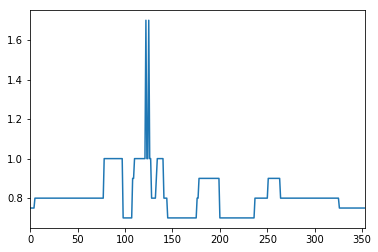

In [36]:
processing_details_bigbag.sifter_speed_nominal_pct.plot()

#### processing_details_dd 

In [116]:
processing_details_dd = load_table("recipe_0_processing_details_dd")
print('processing_details_dd:', processing_details_dd.shape)
processing_details_dd.head()

processing_details_dd: (526, 5)


,orders_details_id,testing_time,steam_preasure,dd_speed,temp_out
0,1,2018-06-04 17:30:00,8.0,7.0,118.0
1,1,2018-06-04 18:30:00,8.0,7.5,118.0
2,1,2018-06-04 19:30:00,8.0,7.5,118.0
3,1,2018-06-04 20:30:00,8.0,7.5,118.0
4,1,2018-06-04 21:30:00,8.0,7.5,118.0


In [117]:
test_during_production = load_table("recipe_0_out_test_during_production")
test_during_production.bulk_density.fillna(method='ffill', inplace=True)
test_during_production['bulk_density'] = test_during_production.bulk_density.apply(lambda x: float(x)).values
test_during_production.head()

,orders_details_id,line_dd,process_order,testing_time,moisture,bulk_density
0,1,DD08,101077345.0,2018-06-04 17:30:00,3.00,240.0
1,1,DD08,101077345.0,2018-06-04 18:30:00,3.39,240.0
2,1,DD08,101077345.0,2018-06-04 19:30:00,3.97,230.0
3,1,DD08,101077345.0,2018-06-04 20:30:00,4.05,200.0
4,1,DD08,101077345.0,2018-06-04 21:30:00,4.00,200.0


In [118]:
processing_details_bigbag.head()

,orders_details_id,bigbag_number,bigbag_filling_time_end,sifter_speed_nominal_pct
0,1,1,2018-06-04 17:20:00,0.75
1,1,2,2018-06-04 19:05:00,0.75
2,1,3,2018-06-04 20:35:00,0.75
3,1,4,2018-06-04 22:15:00,0.75
4,1,5,2018-06-04 23:35:00,0.75


In [120]:
# for find finish time for each processing testing step

def find_finish_time(test_time, filling_times):
    finish_time = test_time
    for filling_time in filling_times:
        filling_time = pd.Timestamp(filling_time)
        if test_time <= filling_time:
            finish_time = filling_time
            break
    return finish_time

processing_details_dd["bigbag_filling_time_end"] = processing_details_dd.apply(lambda x: find_finish_time(x.testing_time, filling_times[x.orders_details_id]), axis=1)
processing_details_dd.head()

,orders_details_id,testing_time,steam_preasure,dd_speed,temp_out,bigbag_filling_time_end
0,1,2018-06-04 17:30:00,8.0,7.0,118.0,2018-06-04 19:05:00
1,1,2018-06-04 18:30:00,8.0,7.5,118.0,2018-06-04 19:05:00
2,1,2018-06-04 19:30:00,8.0,7.5,118.0,2018-06-04 20:35:00
3,1,2018-06-04 20:30:00,8.0,7.5,118.0,2018-06-04 20:35:00
4,1,2018-06-04 21:30:00,8.0,7.5,118.0,2018-06-04 22:15:00


In [121]:
dd_aver = processing_details_dd.groupby("bigbag_filling_time_end").agg({"steam_preasure":np.mean, 'dd_speed':np.mean, 'temp_out':np.mean})
print(dd_aver.shape)
dd_aver.head()

(381, 3)


,steam_preasure,dd_speed,temp_out
bigbag_filling_time_end,,,
2018-06-04 19:05:00,8.0,7.25,118.0
2018-06-04 20:35:00,8.0,7.50,118.0
2018-06-04 22:15:00,8.0,7.50,118.0
2018-06-04 23:35:00,8.0,8.25,113.5
2018-06-05 01:05:00,8.2,8.50,112.0


In [128]:
test_during_production["bigbag_filling_time_end"] = test_during_production.apply(lambda x: find_finish_time(x.testing_time, filling_times[x.orders_details_id]), axis=1)
test_during_production.head()
test_aver = test_during_production.groupby("bigbag_filling_time_end").agg({"moisture":np.mean, 'bulk_density':np.mean})
print(test_aver.shape)


(381, 2)


In [136]:
print('semi_finished_production_out:', semi_finished_production_out.shape)
semi_finished_production_out.head(5)

semi_finished_production_out: (366, 8)


,orders_details_id,bigbag_number,bigbag_filling_time_end,bigbag_filling_duration,bigbag_weight,efficiency,class,time_start
0,1,1,2018-06-04 19:00:00,100.0,409.0,102.0,optimal,2018-06-04 17:20:00
1,1,2,2018-06-04 20:35:00,115.0,460.0,100.0,optimal,2018-06-04 18:40:00
2,1,3,2018-06-04 22:15:00,80.0,368.0,115.0,above,2018-06-04 20:55:00
3,1,4,2018-06-04 23:35:00,80.0,344.0,107.0,optimal,2018-06-04 22:15:00
4,1,5,2018-06-05 01:05:00,90.0,380.0,105.0,optimal,2018-06-04 23:35:00


#### comput start time for each bag filling

In [137]:
semi_finished_production_out["time_start"] = semi_finished_production_out.apply(lambda row: row.bigbag_filling_time_end - pd.Timedelta(minutes=row.bigbag_filling_duration), axis=1)
start_end_times = semi_finished_production_out[["bigbag_filling_time_end", "time_start"]]
start_end_times.to_csv("start_end_times.csv")
start_end_times.head()

,bigbag_filling_time_end,time_start
0,2018-06-04 19:00:00,2018-06-04 17:20:00
1,2018-06-04 20:35:00,2018-06-04 18:40:00
2,2018-06-04 22:15:00,2018-06-04 20:55:00
3,2018-06-04 23:35:00,2018-06-04 22:15:00
4,2018-06-05 01:05:00,2018-06-04 23:35:00


In [138]:
semi_finished_production_out.set_index('bigbag_filling_time_end', inplace=True)
semi_finished_production_out.head()

,orders_details_id,bigbag_number,bigbag_filling_duration,bigbag_weight,efficiency,class,time_start
bigbag_filling_time_end,,,,,,,
2018-06-04 19:00:00,1,1,100.0,409.0,102.0,optimal,2018-06-04 17:20:00
2018-06-04 20:35:00,1,2,115.0,460.0,100.0,optimal,2018-06-04 18:40:00
2018-06-04 22:15:00,1,3,80.0,368.0,115.0,above,2018-06-04 20:55:00
2018-06-04 23:35:00,1,4,80.0,344.0,107.0,optimal,2018-06-04 22:15:00
2018-06-05 01:05:00,1,5,90.0,380.0,105.0,optimal,2018-06-04 23:35:00


In [139]:
print('dd_aver:', dd_aver.shape)
dd_aver.head()

dd_aver: (381, 3)


,steam_preasure,dd_speed,temp_out
bigbag_filling_time_end,,,
2018-06-04 19:05:00,8.0,7.25,118.0
2018-06-04 20:35:00,8.0,7.50,118.0
2018-06-04 22:15:00,8.0,7.50,118.0
2018-06-04 23:35:00,8.0,8.25,113.5
2018-06-05 01:05:00,8.2,8.50,112.0


In [141]:
semi_finished_production_out.head()

,orders_details_id,bigbag_number,bigbag_filling_duration,bigbag_weight,efficiency,class,time_start
bigbag_filling_time_end,,,,,,,
2018-06-04 19:00:00,1,1,100.0,409.0,102.0,optimal,2018-06-04 17:20:00
2018-06-04 20:35:00,1,2,115.0,460.0,100.0,optimal,2018-06-04 18:40:00
2018-06-04 22:15:00,1,3,80.0,368.0,115.0,above,2018-06-04 20:55:00
2018-06-04 23:35:00,1,4,80.0,344.0,107.0,optimal,2018-06-04 22:15:00
2018-06-05 01:05:00,1,5,90.0,380.0,105.0,optimal,2018-06-04 23:35:00


In [163]:
sfp_out_features1 = semi_finished_production_out.join(dd_aver).join(test_aver)
print(sfp_out_features1.shape)
sfp_out_features1.head(5)

(366, 12)


,orders_details_id,bigbag_number,bigbag_filling_duration,bigbag_weight,efficiency,class,time_start,steam_preasure,dd_speed,temp_out,moisture,bulk_density
bigbag_filling_time_end,,,,,,,,,,,,
2018-06-04 19:00:00,1,1,100.0,409.0,102.0,optimal,2018-06-04 17:20:00,NaN,NaN,NaN,NaN,NaN
2018-06-04 20:35:00,1,2,115.0,460.0,100.0,optimal,2018-06-04 18:40:00,8.0,7.50,118.0,4.01,215.0
2018-06-04 22:15:00,1,3,80.0,368.0,115.0,above,2018-06-04 20:55:00,8.0,7.50,118.0,4.00,200.0
2018-06-04 23:35:00,1,4,80.0,344.0,107.0,optimal,2018-06-04 22:15:00,8.0,8.25,113.5,4.04,200.0
2018-06-05 01:05:00,1,5,90.0,380.0,105.0,optimal,2018-06-04 23:35:00,8.2,8.50,112.0,3.84,200.0


In [186]:
data_split = order_details.set_index('id').data_split
data_split.head()

id
1    training
2    training
3    training
4    training
5    training
Name: data_split, dtype: object

In [218]:
example.loc[example.id == 28].data_split

27    test
Name: data_split, dtype: object

In [240]:
#sfp_out_features1['data_split'] = sfp_out_features1.orders_details_id.apply(lambda x: example.loc[example["id"] == x].data_split)
#example.set_index('id')
sfp_out_features1['data_split'] = sfp_out_features1.orders_details_id.apply(lambda x: example.loc[x].data_split)
sfp_out_features1.head()

,orders_details_id,bigbag_number,bigbag_filling_duration,bigbag_weight,efficiency,class,time_start,steam_preasure,dd_speed,temp_out,moisture,bulk_density,data_split,fat,p1,p2,p3,moisture2
bigbag_filling_time_end,,,,,,,,,,,,,,,,,,
2018-06-04 19:00:00,1,1,100.0,409.0,102.0,optimal,2018-06-04 17:20:00,NaN,NaN,NaN,NaN,NaN,training,0.060604,0.537341,0.210579,0.233674,11.4533
2018-06-04 20:35:00,1,2,115.0,460.0,100.0,optimal,2018-06-04 18:40:00,8.0,7.50,118.0,4.01,215.0,training,0.060604,0.537341,0.210579,0.233674,11.4533
2018-06-04 22:15:00,1,3,80.0,368.0,115.0,above,2018-06-04 20:55:00,8.0,7.50,118.0,4.00,200.0,training,0.060604,0.537341,0.210579,0.233674,11.4533
2018-06-04 23:35:00,1,4,80.0,344.0,107.0,optimal,2018-06-04 22:15:00,8.0,8.25,113.5,4.04,200.0,training,0.060604,0.537341,0.210579,0.233674,11.4533
2018-06-05 01:05:00,1,5,90.0,380.0,105.0,optimal,2018-06-04 23:35:00,8.2,8.50,112.0,3.84,200.0,training,0.060604,0.537341,0.210579,0.233674,11.4533


In [191]:
data_split.name.iloc[0]

AttributeError: 'str' object has no attribute 'iloc'

In [173]:
material_usage.fat[1]

0.060604000000000005

In [176]:
sfp_out_features1['fat'] = sfp_out_features1.apply(lambda row: material_usage.fat[row.orders_details_id], axis=1)
sfp_out_features1['p1'] = sfp_out_features1.apply(lambda row: material_usage.p1[row.orders_details_id], axis=1)
sfp_out_features1['p2'] = sfp_out_features1.apply(lambda row: material_usage.p2[row.orders_details_id], axis=1)
sfp_out_features1['p3'] = sfp_out_features1.apply(lambda row: material_usage.p3[row.orders_details_id], axis=1)
sfp_out_features1['moisture2'] = sfp_out_features1.apply(lambda row: material_usage.moisture[row.orders_details_id], axis=1)

In [177]:
sfp_out_features1.head()

,orders_details_id,bigbag_number,bigbag_filling_duration,bigbag_weight,efficiency,class,time_start,steam_preasure,dd_speed,temp_out,moisture,bulk_density,data_split,fat,p1,p2,p3,moisture2
bigbag_filling_time_end,,,,,,,,,,,,,,,,,,
2018-06-04 19:00:00,1,1,100.0,409.0,102.0,optimal,2018-06-04 17:20:00,NaN,NaN,NaN,NaN,NaN,training,0.060604,0.537341,0.210579,0.233674,11.4533
2018-06-04 20:35:00,1,2,115.0,460.0,100.0,optimal,2018-06-04 18:40:00,8.0,7.50,118.0,4.01,215.0,training,0.060604,0.537341,0.210579,0.233674,11.4533
2018-06-04 22:15:00,1,3,80.0,368.0,115.0,above,2018-06-04 20:55:00,8.0,7.50,118.0,4.00,200.0,training,0.060604,0.537341,0.210579,0.233674,11.4533
2018-06-04 23:35:00,1,4,80.0,344.0,107.0,optimal,2018-06-04 22:15:00,8.0,8.25,113.5,4.04,200.0,training,0.060604,0.537341,0.210579,0.233674,11.4533
2018-06-05 01:05:00,1,5,90.0,380.0,105.0,optimal,2018-06-04 23:35:00,8.2,8.50,112.0,3.84,200.0,training,0.060604,0.537341,0.210579,0.233674,11.4533


In [241]:
sfp_out_features1.to_csv("sfp_out_0_features1.csv")

### Walec DD02

In [5]:
w8 = pd.read_csv("w8.csv")
w8['timestamp'] = w8.timestamp.apply(lambda x: pd.Timestamp(x))
w8.head()

,Unnamed: 0,timestamp,steam_pressure_at_the_inlet_of_regulation_unit,product_temperature_at_the_outlet_of_JetCooker,setpoint_of_steam_pressure_at_the_DD_inlet,condensate_temperature_at_DD_outlet,product_temperature_at_the_inlet,setpoint_of_product_temperature,product_at_the_outlet_of_JetCooker,steam_pressure_at_the_inlet_of_JetCooker,steam_pressure_at_the_outlet_of_regulation_unit,product_temperature_at_the_outlet_of_product
0,0,2018-10-28 02:15:29,0.242865,23.914282,0.3,24.333832,26.214565,142.0,0.0,18.96187,0.0,0.0
1,1,2018-10-28 02:15:29,0.242865,23.914282,0.3,24.333832,26.214565,142.0,0.0,18.96187,0.0,0.0
2,2,2018-10-28 02:15:29,0.242865,23.914282,0.3,24.333832,26.214565,142.0,0.0,18.96187,0.0,0.0
3,3,2018-10-28 02:15:29,0.242865,23.914282,0.3,24.333832,26.214565,142.0,0.0,18.96187,0.0,0.0
4,4,2018-10-28 02:15:29,0.242865,23.914282,0.3,24.333832,26.214565,142.0,0.0,18.96187,0.0,0.0


In [44]:
w8 = w8.sort_values(by='timestamp', ascending=True)

In [45]:
start = start_end_times.iloc[0].time_start
end = start_end_times.iloc[-1].bigbag_filling_time_end

w8_short = w8.loc[(w8.timestamp > start) & (w8.timestamp < end)]
w8_short.to_csv("w8_short.csv")

In [10]:
#w8_short = pd.read_csv("w8_short.csv")
#w8_short['timestamp'] = w8_short.timestamp.apply(lambda x: pd.Timestamp(x))
#w8_short_ts = w8_short.timestamp
w8_short_ts.head()

0   2018-06-04 17:20:03
1   2018-06-04 17:20:13
2   2018-06-04 17:20:23
3   2018-06-04 17:20:33
4   2018-06-04 17:20:43
Name: timestamp, dtype: datetime64[ns]

In [11]:
#w8_short = pd.read_csv("w8_short.csv")
#w8_short['timestamp'] = w8_short.timestamp.apply(lambda x: pd.Timestamp(x))
#w8_short_ts = w8_short.timestamp

def find_times(ts, start_end_times):
    r = start_end_times.loc[(start_end_times.time_start < ts) & (start_end_times.bigbag_filling_time_end > ts)]
    if r.shape[0] > 0:
        return pd.Series({'OK':True, 'bigbag_filling_time_end':r.iloc[0].bigbag_filling_time_end})
    #else:
    #    return pd.Series({'OK':False, 'bigbag_filling_time_end':pd.Timestamp("2000-01-01 00:00:0")})

w8_short_ts2 = w8_short_ts.apply(lambda ts: find_times(ts, start_end_times))
w8_short_ts2.to_csv("w8_short_ts2.csv")

KeyboardInterrupt: 

In [6]:
w8_short_ts2

In [5]:
with open("w8_short_2.csv", 'w', encoding='utf8') as fout:
    with open('w8_short.csv', 'r', encoding='utf8') as fin:
        h = fin.readline().strip().split(',')
        h.append('OK')
        h.append('bigbag_filling_time_end')
        hd = dict([(k,i) for i,k in enumerate(h)])
        hi = hd['timestamp']
        fout.write(','.join(h) + '\n')
        for line in fin:
            row = line.strip().split(',')
            ok = False
            d = pd.Timestamp("2000-01-01 00:00:0")
            ts = pd.Timestamp(row[hi])
            r = start_end_times.loc[(start_end_times.time_start < ts) & (start_end_times.bigbag_filling_time_end > ts)]
            if r.size > 0:
                ok = True
                d = r.iloc[0].bigbag_filling_time_end                        
                row.append(str(ok))
                row.append(str(d))
                fout.write(','.join(row) + '\n')

        

,Unnamed: 0,Unnamed: 0.1,timestamp,steam_pressure_at_the_inlet_of_regulation_unit,product_temperature_at_the_outlet_of_JetCooker,setpoint_of_steam_pressure_at_the_DD_inlet,condensate_temperature_at_DD_outlet,product_temperature_at_the_inlet,setpoint_of_product_temperature,product_at_the_outlet_of_JetCooker,steam_pressure_at_the_inlet_of_JetCooker,steam_pressure_at_the_outlet_of_regulation_unit,product_temperature_at_the_outlet_of_product,OK,bigbag_filling_time_end
0,3509073,3509073,2018-06-04 17:20:03,7.989085,106.116913,8.0,171.812469,112.605446,140.0,0.0,18.96187,75.125351,100.0,True,2018-06-04 19:00:00
